# Solar Power Generation Forecast
Parker True

## Introduction

The goal of this exploratory data analysis is to use historical power output and weather data for 3 different solar farms to predict the power output of each farm 24 hours in the future. We will employ statistical methods and machine learning models in order to construct a day ahead power forecasting model.

### Load Solar Training Dataset

Load the data stored in "solar_training.csv" into a dataframe. Parse the TIMESTAMP attribute into its numerical datetime components. Add the power 24 hours ahead as our label, Y. Display the first few rows to view the changes to the dataframe.

In [1]:
import pandas as pd
import numpy as np

# Import solar training data from csv file
solar_train = pd.read_csv("solar_training.csv")

def format_data(solar_data):
    """Create additional data features for date, time, and labels"""
    # Break timestamp into numeric components
    solar_data["YEAR"] = pd.to_numeric(solar_train["TIMESTAMP"].str[:4])
    solar_data["MONTH"] = pd.to_numeric(solar_train["TIMESTAMP"].str[4:6])
    solar_data["DAY"] = pd.to_numeric(solar_train["TIMESTAMP"].str[6:8])
    solar_data["HOUR"] = pd.to_numeric(solar_train["TIMESTAMP"].str[9:11])

    # Add power 24 hours ahead as labels
    Y = solar_data["POWER"][24:].to_numpy()
    solar_data["Y"] = np.concatenate((Y, np.repeat(np.nan, 24)))
    
    return solar_data.dropna()

# Create numeric datetime and label features for training data
solar_train = format_data(solar_train)
solar_train[["TIMESTAMP", "YEAR", "MONTH", "DAY", "HOUR", "POWER", "Y"]].head()

,TIMESTAMP,YEAR,MONTH,DAY,HOUR,POWER,Y
0,20120401 01:00,2012,4,1,1,0.754103,0.656859
1,20120401 02:00,2012,4,1,2,0.555000,0.771410
2,20120401 03:00,2012,4,1,3,0.438397,0.613782
3,20120401 04:00,2012,4,1,4,0.145449,0.554808
4,20120401 05:00,2012,4,1,5,0.111987,0.458910


## Feature Evaluation and Selection

We are trying to predict power output, so let's first take a look at how power changes over time at one of the zones.

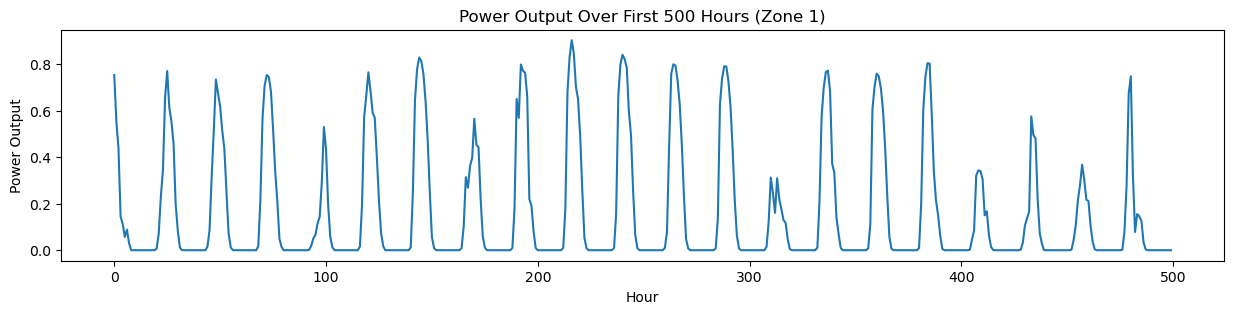

In [2]:
import matplotlib.pyplot as plt

# Visualize power output over time for Zone 1
n_hours_plot = 500

plt.figure(figsize=(15,3))
plt.plot(range(n_hours_plot), solar_train["POWER"][:n_hours_plot])
plt.title(f"Power Output Over First {n_hours_plot} Hours (Zone 1)")
plt.xlabel("Hour")
plt.ylabel("Power Output")
plt.show()

### Check for Multicollinearity in the Data

Analyze the correlation between each pair of variables in the dataset.

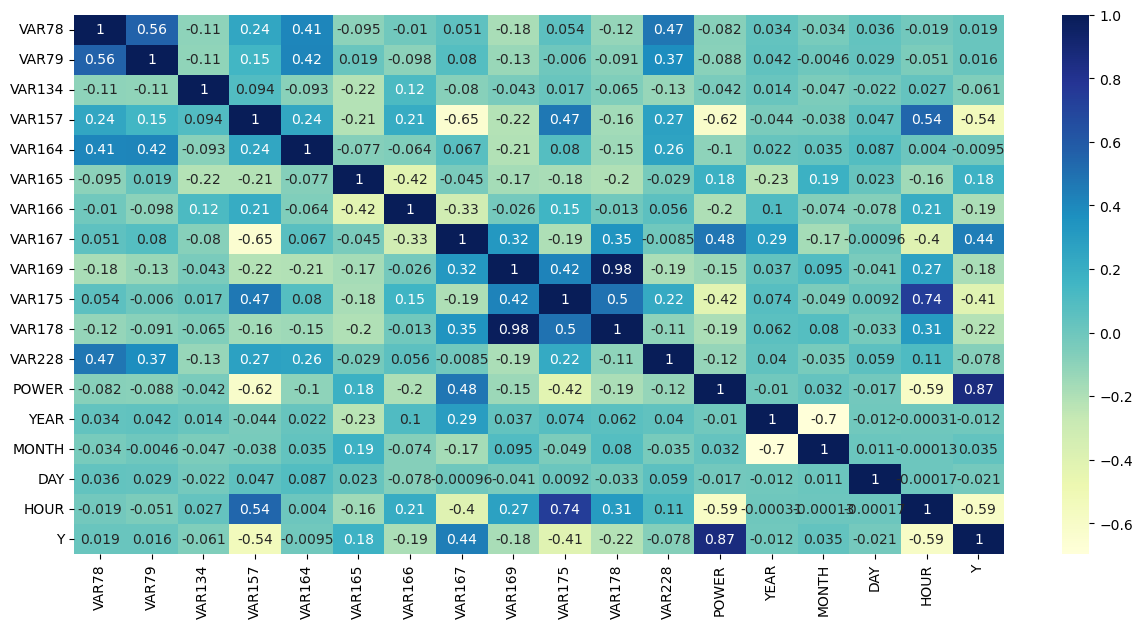

In [3]:
import seaborn as sns

# Plot correlation between all variables
corr_data = solar_train.drop(["ZONEID", "TIMESTAMP"], axis=1)
plt.figure(figsize=(15, 7))
dataplot = sns.heatmap(corr_data.corr(), cmap="YlGnBu", annot=True)

VAR169 (Solar radiation) and VAR178 (Top net solar radiation) have a high correlation coefficient of 0.98, so, to prevent multicollinearity, we only need to consider one of them when making statistical inferences from the data. Of the predictors, only POWER has a significant correlation with Y.

## Select Top Features for Regression Based on F-tests

Use f_regression to select the top k features to include in the models. We will choose to keep the top 7 variables.

In [4]:
from sklearn.feature_selection import SelectKBest, f_regression

# Select all data columns
rm_cols = ["ZONEID", "TIMESTAMP", "Y"]
cols_knn = [col for col in solar_train.columns if col not in rm_cols]

# Select features with best 7 F-values for regression
X_best = solar_train[cols_knn]
k = 7
kbest = SelectKBest(f_regression, k=k)
kbest.fit(X_best, solar_train["Y"])

# Find best 7 features
cols_best = kbest.get_feature_names_out()
print(f"Best {k} features:", cols_best)

Best 7 features: ['VAR157' 'VAR166' 'VAR167' 'VAR175' 'VAR178' 'POWER' 'HOUR']


## Classifier to Detect Night Time

By examining the graph of power over time we see that power output plateaus at 0 every night when there is no sunlight. Therefore, we can train a DecisionTreeClassifier that will use the date and time to classify each sample with a predicted power of 0.

### Group Data

Group the solar data to form the samples and labels for the classifier. The samples will be the features MONTH, DAY, and HOUR while the labels will be 1 if power output is below a certain threshold (night) or 0 otherwise (day).

In [5]:
def group_data_tree(solar_data, zone):
    """Groups data to form samples and labels for night time classifier"""
    # Split data by zone
    solar_data = solar_data[solar_data["ZONEID"] == zone]
    
    # Select datetime columns as training samples
    X = solar_data[["MONTH", "DAY", "HOUR"]]
    
    # Find labels where power is below threshold
    power_threshold = 0.01
    Y = solar_data["Y"] < power_threshold
    
    return X, Y

### Train Model

Train the decision tree classifier to separate night samples from day samples for each zone.

In [6]:
def train_tree(solar_data, param_grid, n_folds, tree):
    """Fit a decision tree classifier to separate day vs. night"""
    trees = []
    
    for zone in range(1, 4):
        # Group data by zone and format for decision tree
        X_train, Y_train = group_data_tree(solar_data, zone)

        # Perform grid search to optimize hyperparameters
        grid_search = GridSearchCV(tree, param_grid, cv=n_folds, scoring='accuracy')
        grid_search.fit(X_train, Y_train)

        # Store and evaluate best tree
        best_tree = grid_search.best_estimator_
        print(f"Best parameters for Zone {zone}:", grid_search.best_params_)
        trees.append(best_tree)
        
    return trees

### Evaluate Classifier

Compute the training accuracy of the decision tree and visualize the night vs. day class compared to power output.

In [7]:
def eval_tree(solar_data, zone, tree):
    """Compute accuracy of decision tree and visualize output"""
    # Make predictions using classifier
    X_tree, Y_tree = group_data_tree(solar_data, zone)
    Y_pred = tree.predict(X_tree)

    # Compute accuracy of classifier
    acc = tree.score(X_tree, Y_tree)
    print(f"Best accuracy for Zone {zone}:", acc)
    
    # Visualize night predictor vs. power output
    n_hours_plot = 500
    power = solar_data[solar_data["ZONEID"] == zone]["POWER"]
    
    plt.figure(figsize=(15, 3))
    plt.plot(range(n_hours_plot), power[:n_hours_plot], "-b", label="Power")
    plt.plot(range(n_hours_plot), np.logical_not(Y_pred[:n_hours_plot]), "-r", label="Predictor")
    plt.title(f"Power Output Vs. Night Predictor (Zone {zone})")
    plt.xlabel("Hour")
    plt.ylabel("Power Output")
    plt.legend(loc="upper right")
    plt.show()

### Train and Evaluate Decision Tree

Train a DecisionTreeClassifier model to predict whether each sample is from night or day for each zone. Then evaluate the training accuracy of the classifier.

Best parameters for Zone 1: {'criterion': 'gini', 'min_samples_leaf': 4}
Best parameters for Zone 2: {'criterion': 'entropy', 'min_samples_leaf': 4}
Best parameters for Zone 3: {'criterion': 'gini', 'min_samples_leaf': 4}
Best accuracy for Zone 1: 0.9913194444444444


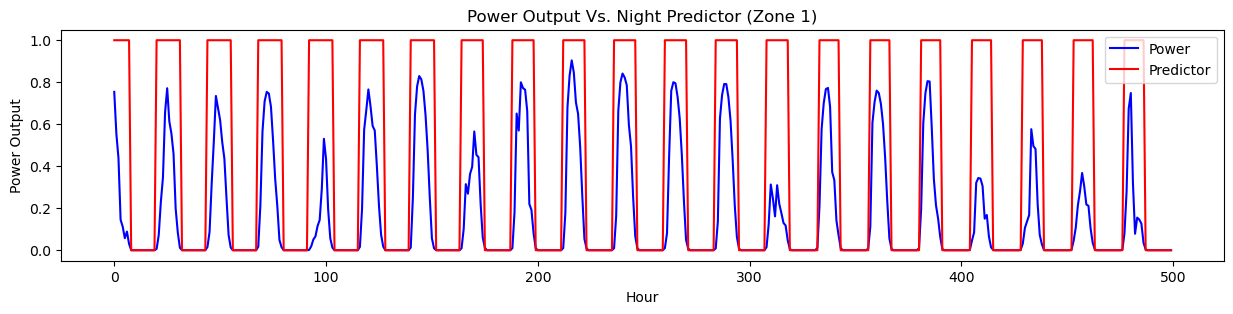

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

n_folds = 3

# Construct decision tree and optimize hyperparameters for each zone
tree = DecisionTreeClassifier()
param_grid = {
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": range(1, 5)
}
trees = train_tree(solar_train, param_grid, n_folds, tree)
    
# Compute accuracy of tree and visualize output for Zone 1
eval_tree(solar_train, 1, trees[0])

Best accuracy for Zone 2: 0.9907711988304093


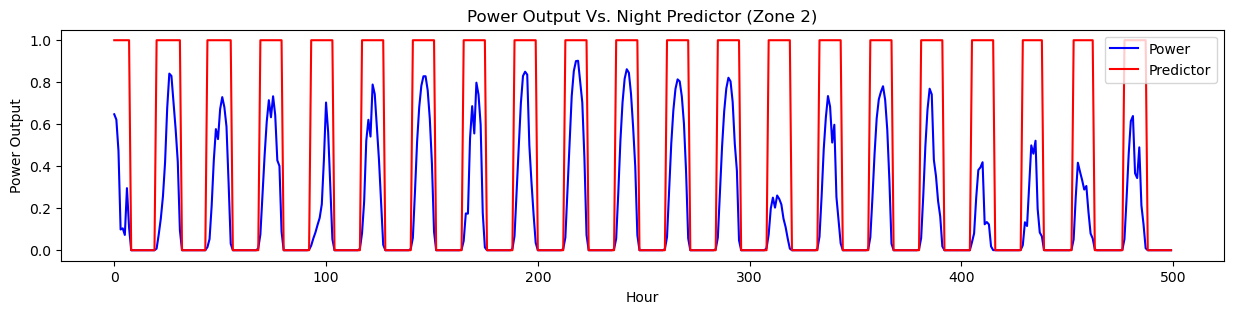

In [9]:
# Compute accuracy of tree and visualize output for Zone 2
eval_tree(solar_train, 2, trees[1])

Best accuracy for Zone 3: 0.9913919413919414


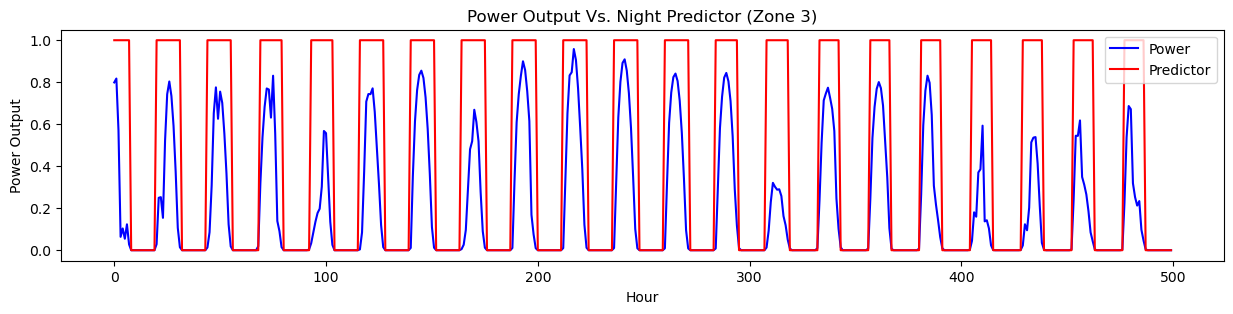

In [10]:
# Compute accuracy of tree and visualize output for Zone 3
eval_tree(solar_train, 3, trees[2])

The classifier for each of our 3 zones all have high training accuracies above 99%. Additionally, from the plot of our night predictor versus the power output for the first 500 hours in each zone, we can see the predictor coincides well with the plateaus where power output is 0.

## Regression Models for Power

### Group Samples

In order to consider more historical data in our regression models, we want to consider measurements taken across multiple hours prior to the time of prediction. To accomplish this, create a new dataset where each sample will include the measurements from multiple consecutive hours as determined by the parameter n_hours. For example, if we want to predict the power at hour 124 with n_hours=3, the input sample would include the measurements from hours 100, 99, and 98. Use the step parameter to set the step between samples. When training the model, we can remove all samples that will be classified as night time, as the prediction will automatically be 0. Use StandardScaler to standardize the data. 

In [11]:
from sklearn.preprocessing import StandardScaler

def group_data_reg(solar_data, zone, cols, n_hours, step, train=False):
    """Groups data to form samples and labels for regression model."""
    # Split data by zone
    solar_data = solar_data[solar_data["ZONEID"] == zone]
    
    # Group records to form samples
    X = solar_data[cols]
    n = X.shape[0]
    idx = range(0, n_hours, step)
    X = np.concatenate([X[n_hours-i:n-i] for i in idx], axis=1)
  
    # Use power as labels
    Y = solar_data["POWER"][n_hours:]
    
    if train:
        # Remove night time samples
        power_threshold = 0.01
        day = Y >= power_threshold
        X, Y = X[day], Y[day]
    
    # Standardize the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    return X, Y

### Train Regression Models

For each of the 3 zones, fit a regression model to the training data and optimize the hyperparameters using GridSearchCV to minimize mean absolute error.

In [12]:
def train_reg(solar_data, param_grid, n_folds, cols, n_hours, step, reg):
    """Train regression model using grid search"""
    regs = []
    
    for zone in range(1, 4):
        # Group data by zone
        X_train, Y_train = group_data_reg(solar_data, zone, cols, n_hours, step, train=True)

        # Perform grid search to optimize hyperparameters
        grid_search = GridSearchCV(reg, param_grid, cv=n_folds, scoring="neg_mean_absolute_error")
        grid_search.fit(X_train, Y_train)

         # Store and evaluate best regression model
        best_reg = grid_search.best_estimator_
        regs.append(best_reg)
        print(f"Best parameters for Zone {zone}:", grid_search.best_params_)
        
    return regs

### Evaluate Regression Model

Calculate the mean absolute error and root mean squared error of a model and visualize the predicted power output versus the expected power output.

In [13]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

def eval_reg(solar_data, zone, tree, cols, n_hours, step, reg):
    """Compute error metrics and plot predictions for a regression model"""
    # Make predictions on solar data
    X_test, Y_test = group_data_reg(solar_data, zone, cols, n_hours, step)
    Y_pred = reg.predict(X_test)
    
    # Set night samples to 0
    X_tree, Y_tree = group_data_tree(solar_data, zone)
    night = tree.predict(X_tree)
    Y_pred[night[n_hours:]] = 0
    
    # Remove negative predictions
    Y_pred[Y_pred < 0] = 0

    # Compute mean absolute error and root mean squared error
    print(f"Mean absolute error for Zone {zone}:", mean_absolute_error(Y_test, Y_pred))
    print(f"Root mean squared error for Zone {zone}", mean_squared_error(Y_test, Y_pred, squared=False))

    # Visualize true vs. predicted power output
    n_hours_plot = 500
    
    plt.figure(figsize=(15, 3))
    plt.plot(range(n_hours_plot), Y_test[:n_hours_plot], "-b", label="True Power")
    plt.plot(range(n_hours_plot), Y_pred[:n_hours_plot], "-r", label="Predicted Power")
    plt.title(f"True Power Output Vs. Predicted Power Output (Zone {zone})")
    plt.legend(loc="upper right")
    plt.xlabel("Hour")
    plt.show()

### Neural Network Regression Model

Fit an MLPRegressor regression model to the training data, tune the hyperparameters using GridSearchCV, and evaluate the training error.

Best parameters for Zone 1: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (10, 10)}
Best parameters for Zone 2: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (10, 10)}
Best parameters for Zone 3: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (10, 10)}

Mean absolute error for Zone 1: 0.08032009031451791
Root mean squared error for Zone 1 0.14537384805599382


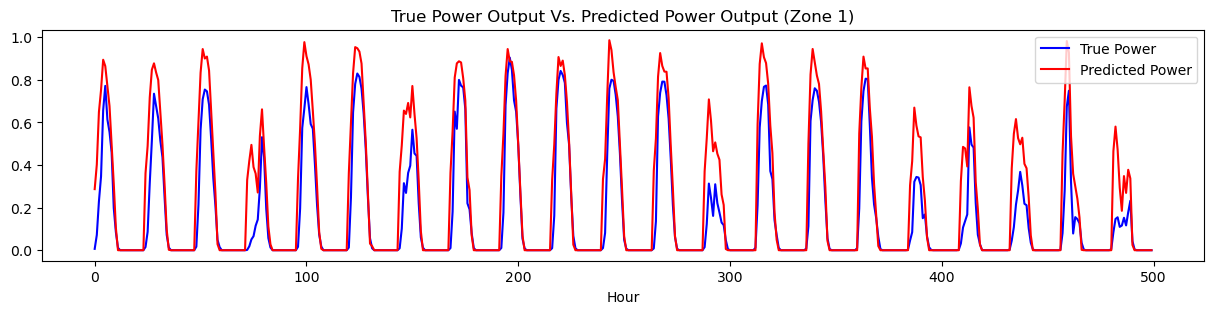

In [14]:
from sklearn.neural_network import MLPRegressor

n_hours_mlp = 20
step_mlp = 2
cols_mlp = cols_best

# Train neural network regressor
mlp = MLPRegressor()
param_grid = {
 'hidden_layer_sizes' : [(10,10), (20,20)],
 'activation' : ['tanh', 'relu'],
 'alpha' : [0.0001, 0.001, 0.01],
}
mlps = train_reg(solar_train, param_grid, n_folds, cols_mlp, n_hours_mlp, step_mlp, mlp)

print("")

# Evaluate neural network regressor for Zone 1
eval_reg(solar_train, 1, trees[0], cols_mlp, n_hours_mlp, step_mlp, mlps[0])

Mean absolute error for Zone 2: 0.11920142130281133
Root mean squared error for Zone 2 0.20231176739332893


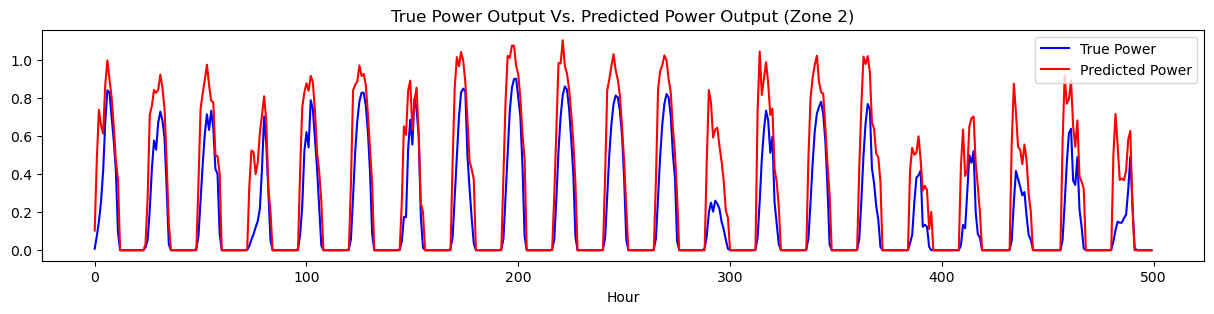

In [15]:
# Evaluate neural network regressor for Zone 2
eval_reg(solar_train, 2, trees[1], cols_mlp, n_hours_mlp, step_mlp, mlps[1])

Mean absolute error for Zone 3: 0.08724285328032835
Root mean squared error for Zone 3 0.15246735247552942


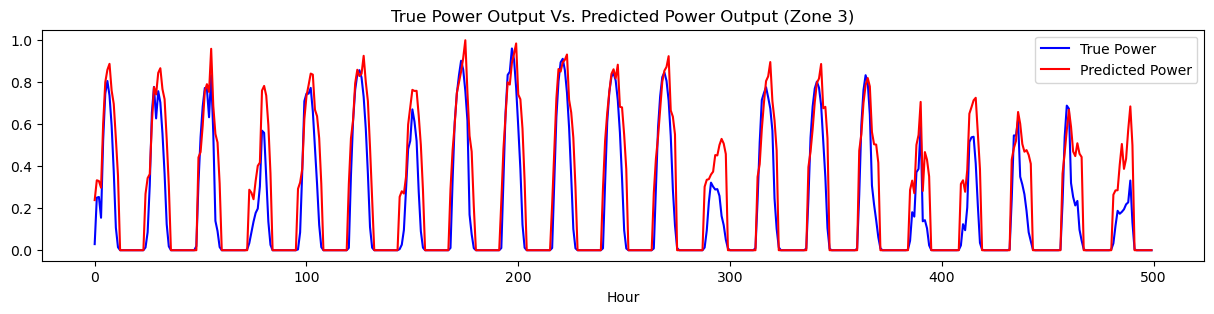

In [16]:
# Evaluate neural network regressor for Zone 3
eval_reg(solar_train, 3, trees[2], cols_mlp, n_hours_mlp, step_mlp, mlps[2])

### K-Nearest Neighbors Regression Model

Fit an KNeighborsRegressor regression model to the training data, tune the hyperparameters using GridSearchCV, and evaluate the training error.

Best parameters for Zone 1: {'leaf_size': 2, 'n_neighbors': 5, 'p': 2}
Best parameters for Zone 2: {'leaf_size': 2, 'n_neighbors': 3, 'p': 2}
Best parameters for Zone 3: {'leaf_size': 2, 'n_neighbors': 3, 'p': 2}

Mean absolute error for Zone 1: 0.03958339074855523
Root mean squared error for Zone 1 0.08358750031669573


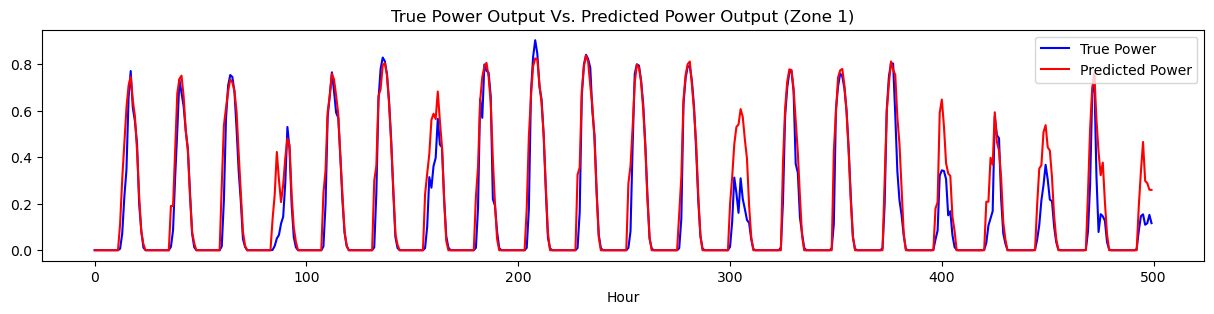

In [17]:
from sklearn.neighbors import KNeighborsRegressor

n_hours_knn = 8
step_knn = 1
cols_knn = cols_best

# Train random forest regressor
knn = KNeighborsRegressor()
param_grid = {
    'n_neighbors': [3, 5, 7],
    'leaf_size': [2, 5, 10],
    'p': [1, 2]
}

knns = train_reg(solar_train, param_grid, n_folds, cols_knn, n_hours_knn, step_knn, knn)

print("")

# Evaluate K-neearest neighbors regressor for Zone 1
eval_reg(solar_train, 1, trees[0], cols_knn, n_hours_knn, step_knn, knns[0])

Mean absolute error for Zone 2: 0.04221166465499268
Root mean squared error for Zone 2 0.08225891188051435


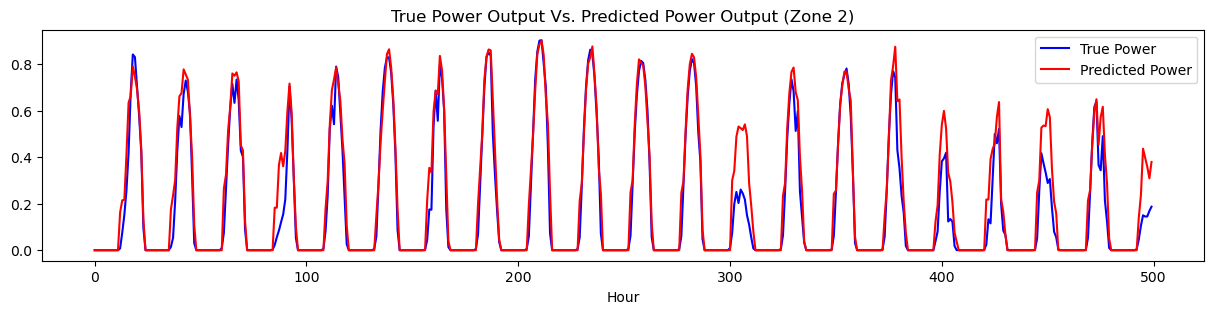

In [18]:
# Evaluate K-neearest neighbors regressor for Zone 2
eval_reg(solar_train, 2, trees[1], cols_knn, n_hours_knn, step_knn, knns[1])

Mean absolute error for Zone 3: 0.045301719819159335
Root mean squared error for Zone 3 0.093446061889911


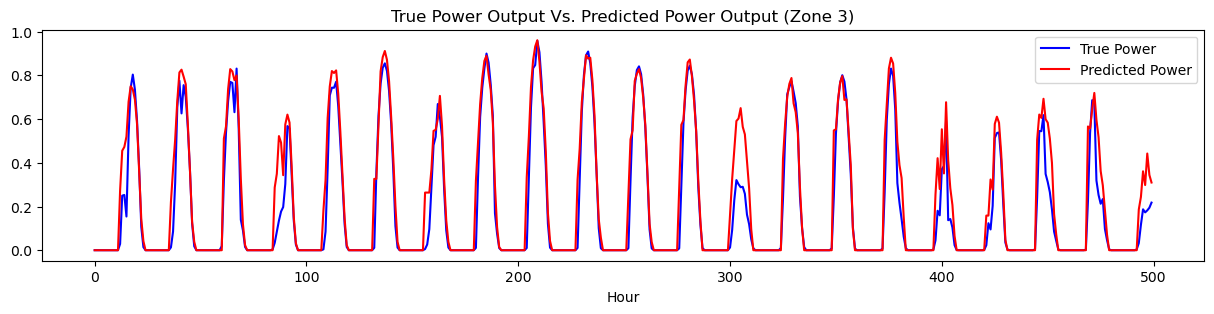

In [19]:
# Evaluate K-neearest neighbors regressor for Zone 3
eval_reg(solar_train, 3, trees[2], cols_knn, n_hours_knn, step_knn, knns[2])

### Random Forest Regression Model

Fit an RandomForestRegressor regression model to the training data, tune the hyperparameters using GridSearchCV, and evaluate the training error.

Best parameters for Zone 1: {'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 8, 'n_estimators': 100}
Best parameters for Zone 2: {'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 200}
Best parameters for Zone 3: {'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100}

Mean absolute error for Zone 1: 0.07592413397378805
Root mean squared error for Zone 1 0.1235999655254355


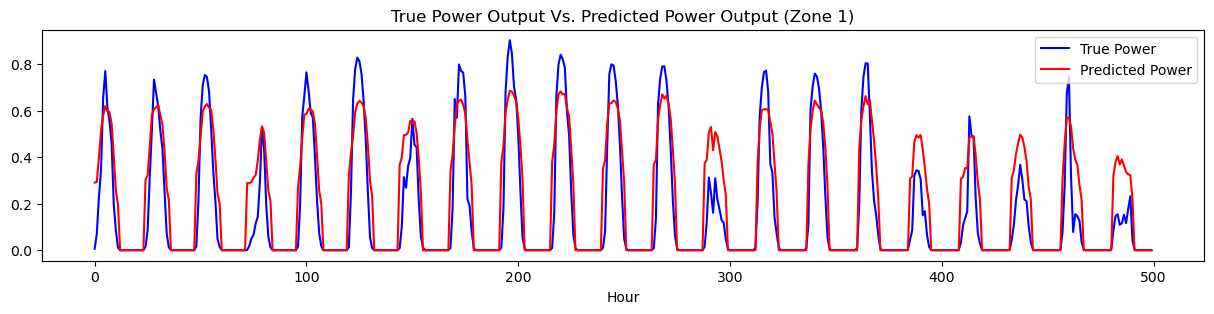

In [20]:
from sklearn.ensemble import RandomForestRegressor

n_hours_rf = 20
step_rf = 1
cols_rf = cols_best

# Train random forest regressor
rf = RandomForestRegressor()
param_grid = {
    'max_depth': [10, 20, 50],
    'min_samples_split': [2, 4, 8],
    'max_features': ['log2'], 
    'n_estimators': [100, 200, 300]
}

rfs = train_reg(solar_train, param_grid, n_folds, cols_rf, n_hours_rf, step_rf, rf)

print("")

# Evaluate Random forest regressor for Zone 1
eval_reg(solar_train, 1, trees[0], cols_rf, n_hours_rf, step_rf, rfs[0])

Mean absolute error for Zone 2: 0.07739659475653923
Root mean squared error for Zone 2 0.13012635391762448


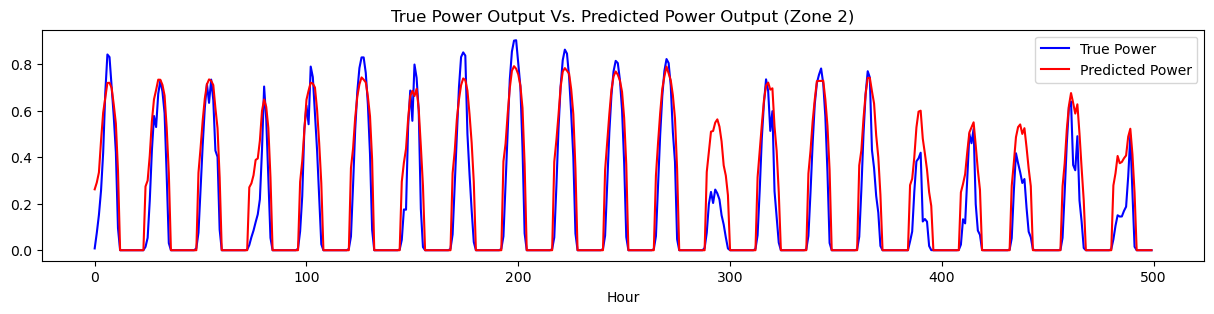

In [21]:
# Evaluate Random forest regressor for Zone 2
eval_reg(solar_train, 2, trees[1], cols_rf, n_hours_rf, step_rf, rfs[1])

Mean absolute error for Zone 3: 0.07444643162844038
Root mean squared error for Zone 3 0.1253505802444057


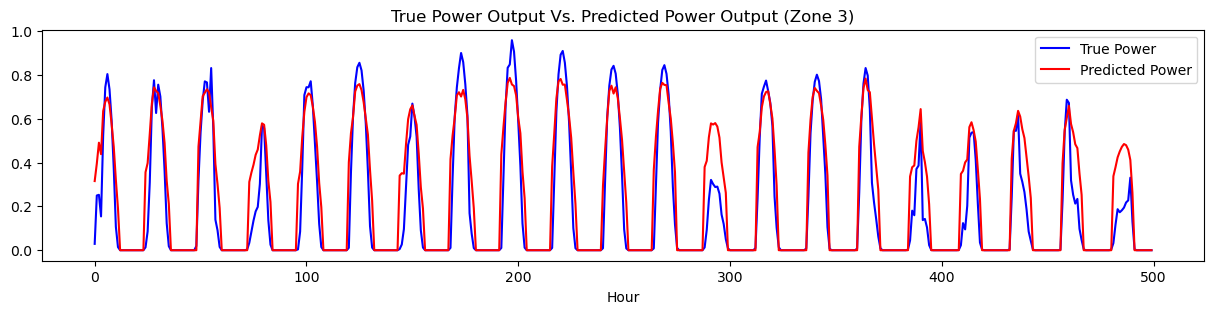

In [22]:
# Evaluate Random forest regressor for Zone 3
eval_reg(solar_train, 3, trees[2], cols_rf, n_hours_rf, step_rf, rfs[2])

## Build  and Evaluate Solar Power Forecasting Model

After analyzing multiple regression models using varying amounts of historical data, the model with the lowest mean absolute error and root mean squared error across all 3 zones is the k-nearest neighbors model. Therefore, we will choose to use this in our final power forecasting model. This will only be responsible for predicting the power output for day time samples, as the decision tree classifier will be used to automatically predict the power for any night samples as 0.

### Forecast Model

Construct a model using the trained classifiers to predict the power 24 hours ahead for the test data.

In [23]:
def forecast(solar_data, zone, tree,
               cols_knn, n_hours_knn, step_knn, knn):
    """Predict solar power output for test data"""
    # Make predictions using k-nearest neighbors regression model
    X_test, _ = group_data_reg(solar_data, zone, cols_knn, n_hours_knn, step_knn)
    Y_pred = knn.predict(X_test)
    n = len(Y_pred)
    
    # Classify night samples and predict power as 0
    X_test, _ = group_data_tree(solar_data, zone)
    night = tree.predict(X_test)[-n:]
    Y_pred[night] = 0
    
    # Remove negative predictions
    Y_pred[Y_pred < 0] = 0
    
    return Y_pred

### Evaluate the Forecast Model

Compute the mean absolute error and root mean squared error of the model for a given zone. Vizualize the predicted power output from the model versus the true test power output.

In [24]:
def eval_model(solar_data, zone, tree,
               cols_knn, n_hours_knn, step_knn, knn):
    """Evaluate error metrics for forecast model and visualize output"""
    # Make predictions for test data
    Y_pred = forecast(solar_data, zone, tree,
                      cols_knn, n_hours_knn, step_knn, knn)
    
    # Get test labels
    Y_test = solar_test[solar_test["ZONEID"] == zone]
    n = len(Y_pred)
    Y_test = Y_test["POWER"][-n:]

    # Compute mean absolute error and root mean squared error
    print(f"Mean absolute error for Zone {zone}:", mean_absolute_error(Y_test, Y_pred))
    print(f"Root mean squared error for Zone {zone}", mean_squared_error(Y_test, Y_pred, squared=False))
    
    # Visualize first 500 power predictions
    n_hours_plot = 500
    
    plt.figure(figsize=(15, 3))
    plt.plot(range(n_hours_plot), solar_test["Y"][-n:-n+n_hours_plot], c="blue", label="True Power")
    plt.plot(range(n_hours_plot), Y_pred[:n_hours_plot], c="red", label="Predicted Power")
    plt.title(f"Power Output Over First {n_hours_plot} Hours (Zone {zone})")
    plt.legend(loc="upper right")
    plt.xlabel('Hour')
    plt.ylabel('Power Output')
    plt.show()

### Import Test Data and Run Solar Power Forecast Model

Make predictions on the test data using our forecast model. Compute the mean absolute error and root mean squared error for each zone.

Mean absolute error for Zone 1: 0.04956155662920476
Root mean squared error for Zone 1 0.09892958555364818


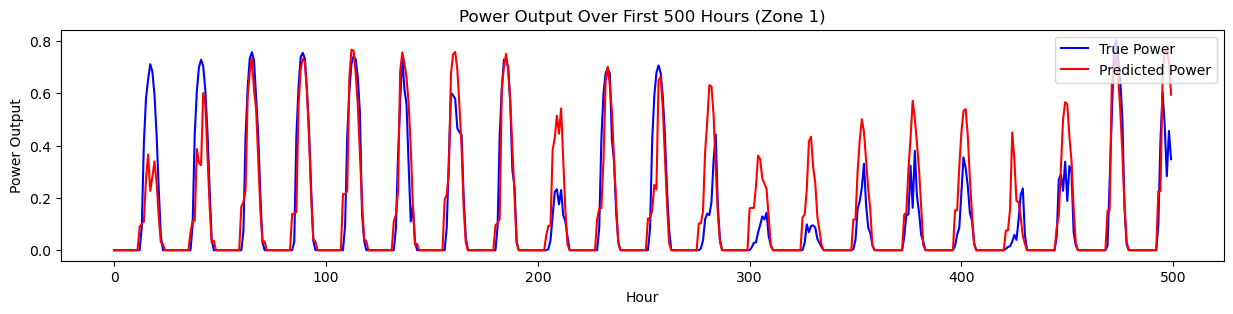

In [25]:
# Import and format solar test data from csv file
solar_test = pd.read_csv("solar_test.csv")
solar_test = format_data(solar_test)

# Compute error metrics and visualize output of our model for Zone 1
eval_model(solar_test, 1, trees[0],
           cols_knn, n_hours_knn, step_knn, knns[0])

Mean absolute error for Zone 2: 0.05895535341114412
Root mean squared error for Zone 2 0.11204737638349567


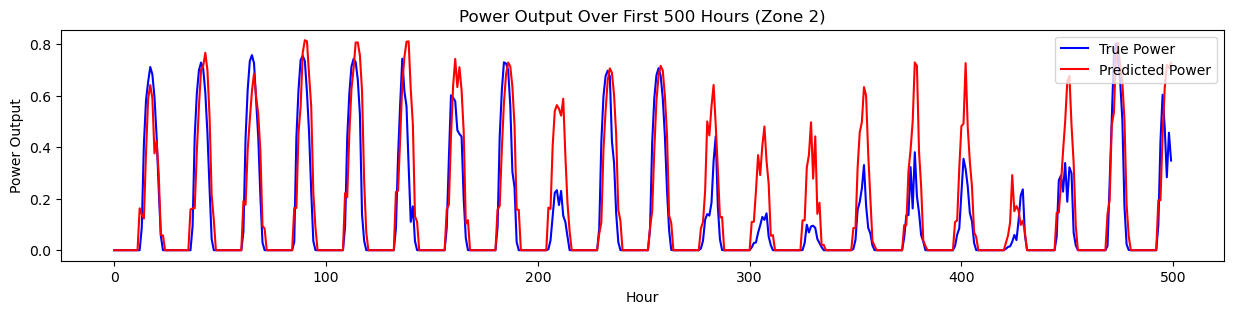

In [26]:
# Compute error metrics and visualize output of our model for Zone 2
eval_model(solar_test, 2, trees[1],
           cols_knn, n_hours_knn, step_knn, knns[1])

Mean absolute error for Zone 3: 0.06509271597158571
Root mean squared error for Zone 3 0.12437714702144104


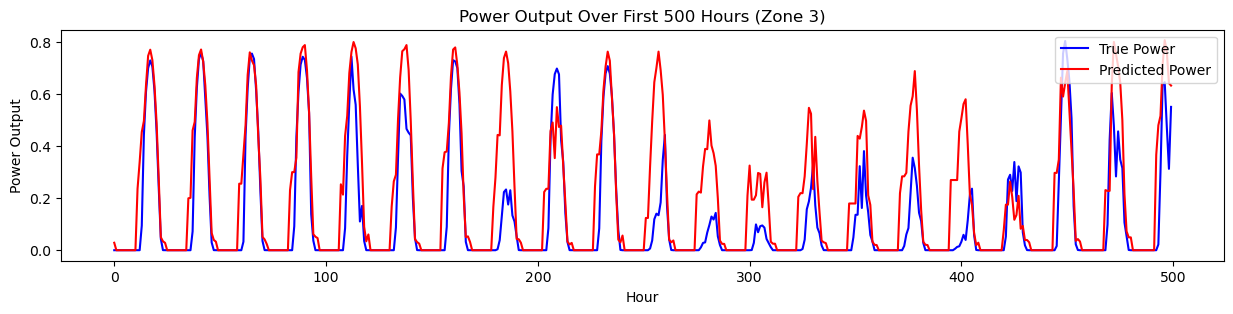

In [27]:
# Compute error metrics and visualize output of our model for Zone 3
eval_model(solar_test, 3, trees[2],
           cols_knn, n_hours_knn, step_knn, knns[2])

## Conclusion

Comparing the predicted power output from our classifier versus the true power for the test data yields the following error measurements: 

| Zone | Mean Absolute Error | Root Mean Squared Error |
| - | - | - |
| 1 | 0.0496 | 0.0989 |
| 2 | 0.0590 | 0.1120 |
| 3 | 0.0651 | 0.1244 |
| Average | 0.0579 | 0.1118 |

After experimenting with numerous classifiers using varying amounts of historical data, the models I found to be the most useful for day ahead solar power forecasting is a k-nearests neighbors regression model. It is important to note that because of the way the model forms samples from the data, we do need 8 hours of historical measurements before we can begin making predictions.

With an average mean absolute error of 5.79% for the 3 zones, the model makes for a reasonably accurate tool for day ahead forecasting, however, the error is not so low as to be able to make confident hour by hour predictions 24 hours ahead. This is confirmed when we plot the predicted power output with the true power output for our test data, as we see the model follows the true power curve closely at some points but varies widely at others. The most frequent and substantial error made by the model are days where the predicted power curve extends significantly higher than the true power curve. In terms of the practicallity of this model to forecast power, although we do see significant variance in the model at times, we are generally able to predict overall trends, such as whether or not the maximum power output for a day will be higher or lower than the previous day.